In [1]:
# Import required libraries
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append('src')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ultralytics import YOLO

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Dataset Preparation

In [2]:
# Prepare dataset
from prepare_dataset import DatasetPreparer

# Initialize preparer
preparer = DatasetPreparer(
    source_dir="DATASET - To Students",
    output_dir="dataset"
)

# Prepare dataset
preparer.prepare_dataset(test_size=0.15, val_size=0.15)

# Display statistics
preparer.print_statistics()

🔍 Scanning source directory...
📊 Found 482 total images
📚 Train: 347 | Val: 62 | Test: 73

⚙️  Processing train set...


train:  93%|█████████▎| 322/347 [00:27<00:03,  8.24it/s]Premature end of JPEG file
Premature end of JPEG file
train: 100%|██████████| 347/347 [00:30<00:00, 11.49it/s]



⚙️  Processing val set...


val: 100%|██████████| 62/62 [00:05<00:00, 11.95it/s]



⚙️  Processing test set...


test: 100%|██████████| 73/73 [00:06<00:00, 11.07it/s]


📄 Created data.yaml at: dataset/data.yaml

✅ Dataset preparation complete!

DATASET STATISTICS
Total images scanned: 482
Successfully processed: 452
Faces detected: 452
Skipped images: 30

Emotion Distribution:
--------------------------------------------------
Angry          :    56
Disgust        :    73
Fear           :    72
Happy          :    69
Neutral        :    73
Sad            :    69
Surprised      :    40

DATASET STATISTICS
Total images scanned: 482
Successfully processed: 452
Faces detected: 452
Skipped images: 30

Emotion Distribution:
--------------------------------------------------
Angry          :    56
Disgust        :    73
Fear           :    72
Happy          :    69
Neutral        :    73
Sad            :    69
Surprised      :    40


## 2. Visualize Sample Data

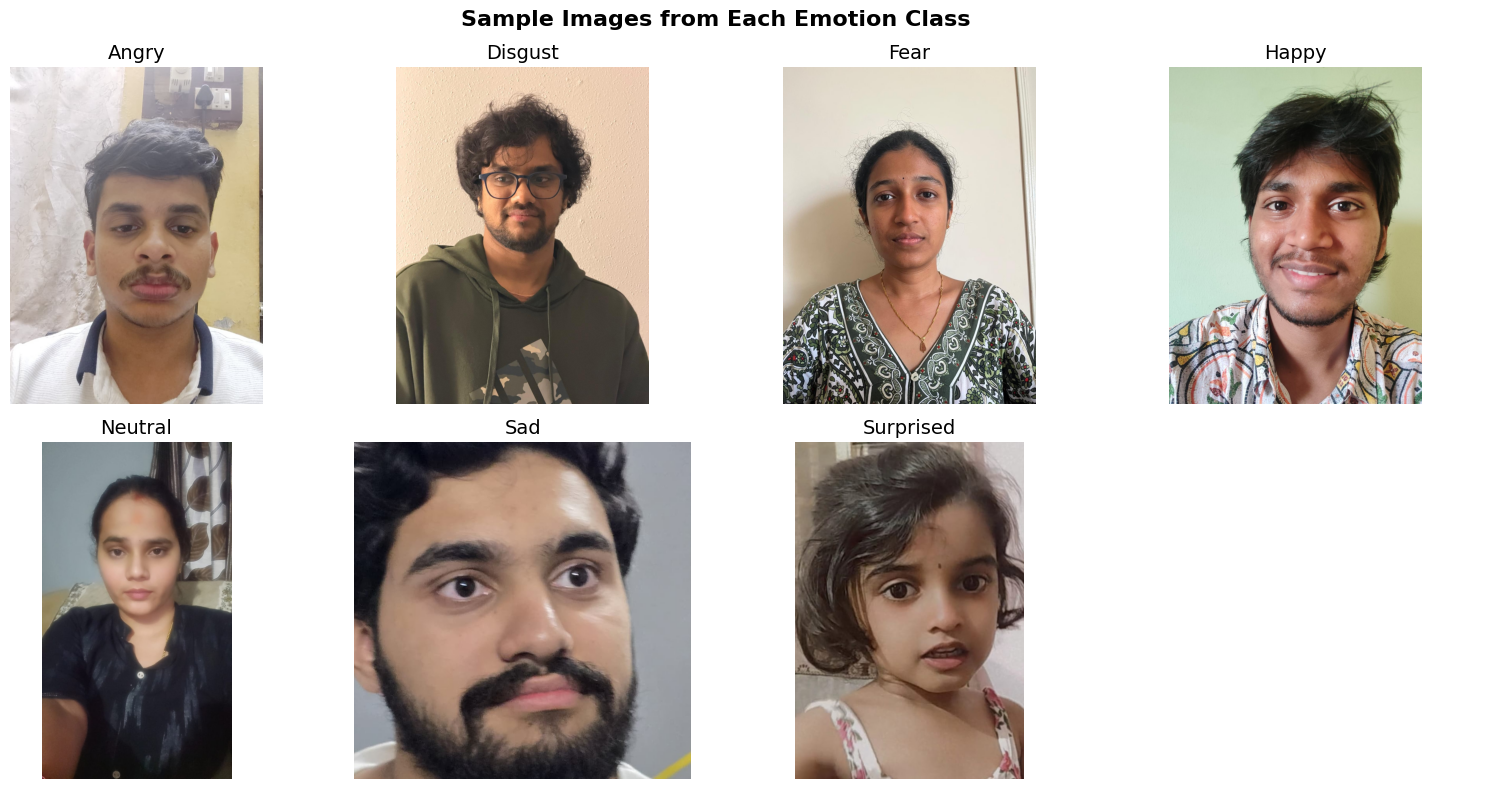

In [3]:
# Visualize sample images from each emotion
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']
train_images_dir = Path('dataset/images/train')

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, emotion in enumerate(emotions):
    # Find an image with this emotion
    images = [img for img in train_images_dir.glob(f'{emotion}_*.jpg')]
    
    if images:
        img = cv2.imread(str(images[0]))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(emotion.capitalize(), fontsize=14)
        axes[idx].axis('off')

# Hide the last subplot
axes[-1].axis('off')

plt.suptitle('Sample Images from Each Emotion Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Train Model

In [5]:
import torch

# Initialize YOLO model
model = YOLO('yolov8n.pt')  # Load pretrained model

# Train
device = 0 if torch.cuda.is_available() else ('mps' if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else 'cpu')

results = model.train(
    data='dataset/data.yaml',
    epochs=50,  # Reduced for notebook
    batch=16,
    imgsz=640,
    device=device,  # Auto-select GPU if available, else CPU
    project='runs/train',
    name='facial_expression_notebook',
    exist_ok=True,  # Allow reusing the same run directory
    verbose=True,
    plots=True
)

print("✅ Training complete!")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.9.1 MPS (Apple M4 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=facial_expression_notebook, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

## 4. Visualize Training Results

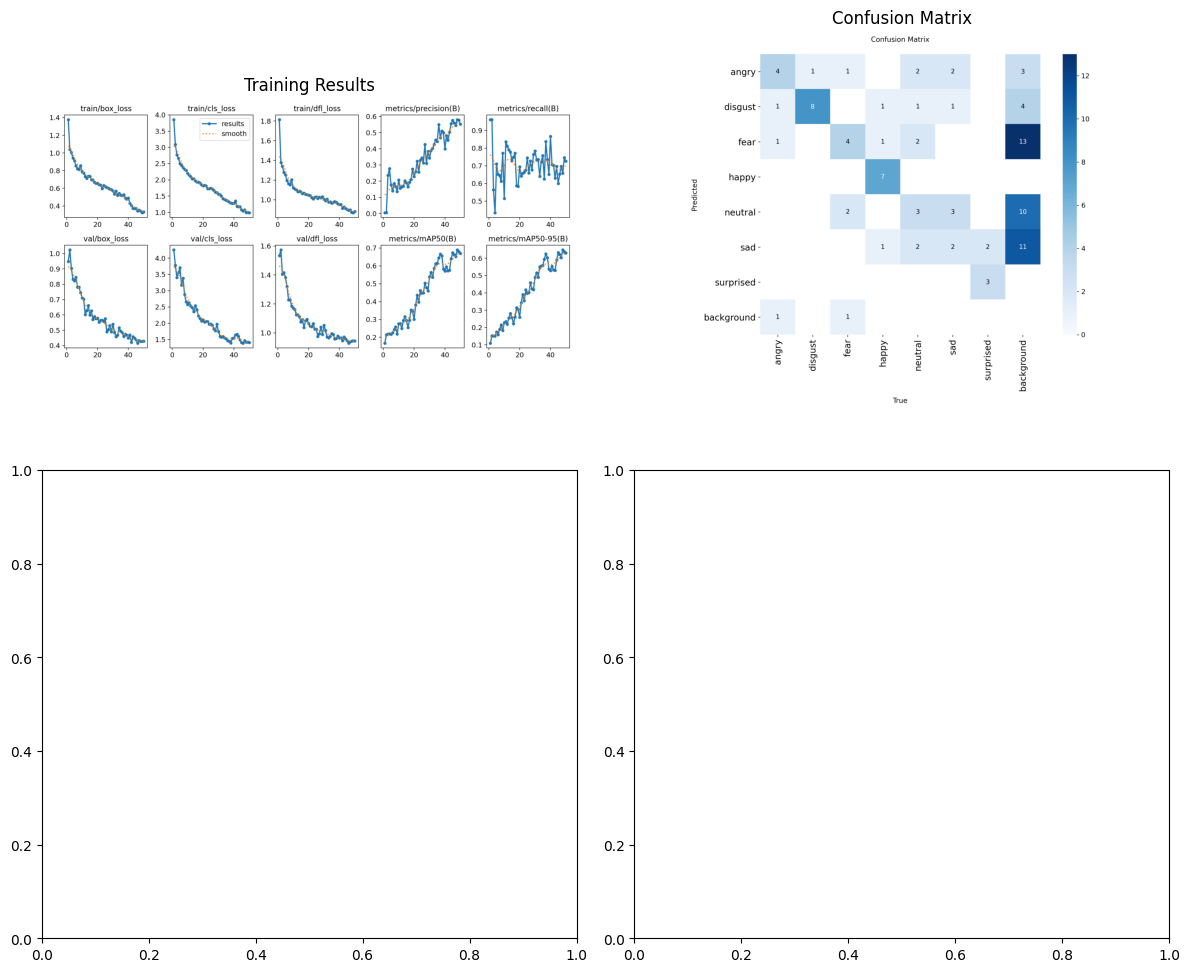

In [6]:
# Display training curves
results_dir = Path('runs/train/facial_expression_notebook')

# Loss curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

images = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']
titles = ['Training Results', 'Confusion Matrix', 'F1 Curve', 'Precision-Recall Curve']

for ax, img_name, title in zip(axes.flatten(), images, titles):
    img_path = results_dir / img_name
    if img_path.exists():
        img = plt.imread(str(img_path))
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Model Evaluation

In [7]:
# Load best model
best_model = YOLO('runs/train/facial_expression_notebook/weights/best.pt')

# Validate on test set
metrics = best_model.val(data='dataset/data.yaml', split='test')

# Print metrics
print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print("="*60)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.9.1 CPU (Apple M4 Pro)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 439.3±296.7 MB/s, size: 138.0 KB)
val: Scanning /Users/likhith/Documents/EDL_Facial_Expression_Recognition_System/dataset/labels/test.cache... 67 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 67/67 347.8Kit/s 0.0s
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 439.3±296.7 MB/s, size: 138.0 KB)
val: Scanning /Users/likhith/Documents/EDL_Facial_Expression_Recognition_System/dataset/labels/test.cache... 67 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 67/67 347.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.3s/it 6.5s2.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━

## 6. Test on Sample Images

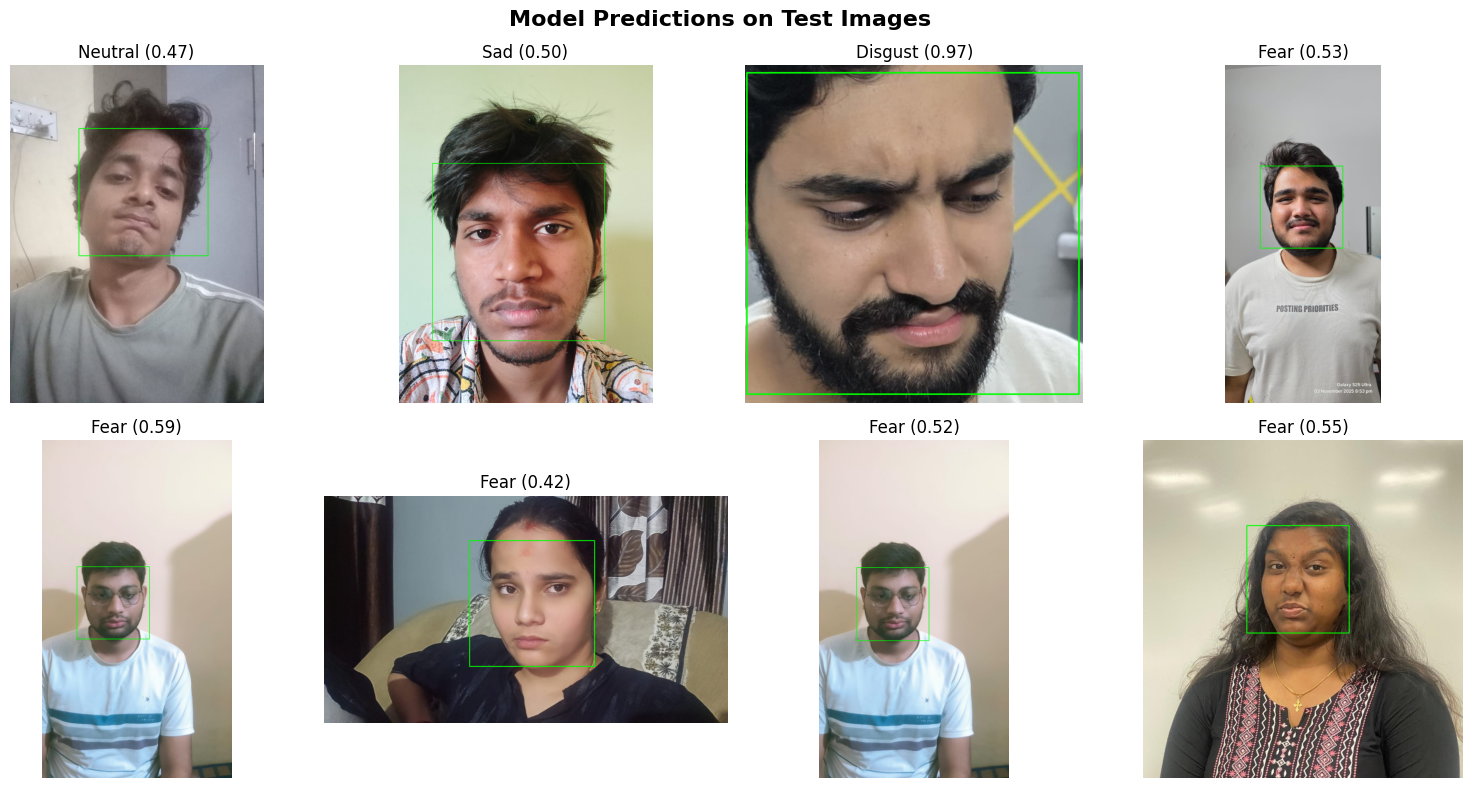

In [8]:
# Get sample test images
test_images_dir = Path('dataset/images/test')
test_images = list(test_images_dir.glob('*.jpg'))[:8]

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Create predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, img_path in enumerate(test_images):
    # Read image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Predict
    results = best_model.predict(str(img_path), verbose=False)[0]
    
    # Annotate
    if results.boxes is not None and len(results.boxes) > 0:
        box = results.boxes[0]
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        
        # Draw box
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        title = f"{emotion_labels[cls]} ({conf:.2f})"
    else:
        title = "No detection"
    
    # Display
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(title, fontsize=12)
    axes[idx].axis('off')

plt.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Real-time Webcam Detection (Optional)

In [ ]:
# Note: This cell is for demonstration only
# For actual webcam usage, run: python src/predict.py --source 0

print("To use real-time webcam detection, run the following command in terminal:")
print("python src/predict.py --source 0 --save")
print("\nControls:")
print("- Press 'q' to quit")
print("- Press 's' to save screenshot")

## 8. Export Model

In [9]:
# Export model to different formats
print("Exporting model to ONNX format...")
onnx_path = best_model.export(format='onnx')
print(f"✅ Model exported to: {onnx_path}")

# You can also export to other formats:
# best_model.export(format='torchscript')
# best_model.export(format='coreml')  # For iOS
# best_model.export(format='tflite')  # For mobile

Exporting model to ONNX format...
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.9.1 CPU (Apple M4 Pro)

PyTorch: starting from 'runs/train/facial_expression_notebook/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 11, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...

PyTorch: starting from 'runs/train/facial_expression_notebook/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 11, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "onnx>=1.12.0,<=1.19.1" "onnxslim>=0.1.71" "onnxruntime" ' returned non-zero exit status 127.
WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "onnx>=1.12.0,<=1.19.1" "onnxslim>=0.1.71" "onnxruntime" ' returned non-zero e

ModuleNotFoundError: No module named 'onnx'

## Summary

In this notebook, we:
1. ✅ Prepared the facial expression dataset
2. ✅ Visualized sample data
3. ✅ Trained a YOLOv8 model
4. ✅ Evaluated model performance
5. ✅ Tested on sample images
6. ✅ Exported the model

### Next Steps:
- Fine-tune hyperparameters for better performance
- Collect more diverse training data
- Deploy the model in a web application
- Integrate with mobile applications

### Resources:
- [YOLOv8 Documentation](https://docs.ultralytics.com/)
- [Project GitHub](https://github.com/Likhith257/EDL_Facial_Expression_Recognition_System)